In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier


pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [12]:
# Load the full CI logs dataset
df = pd.read_csv("../data/all_logs_aug.csv")

# Preview structure
df.head()


,timestamp,command,duration_s,exit_code,cpu_pct_avg,mem_kb_max,tag,status,pipeline_id
0,2025-06-15 07:52:08,"docker login -u ""gitlab-ci-token"" -p ""glcbt-ey...",0.50,0,6.10,0.0,build,pass,NaN
1,2025-06-15 07:53:36,"docker build -t ""registry.gitlab.com/uhthesis/...",87.66,0,41.04,44680.0,build,pass,NaN
2,2025-06-15 07:54:30,"docker push ""registry.gitlab.com/uhthesis/bids...",53.10,0,55.44,36724.0,build,pass,NaN
3,2025-06-15 07:55:27,flake8 .,1.00,0,48.50,22424.0,lint,pass,NaN
4,2025-06-15 07:56:24,python manage.py collectstatic --noinput,0.50,0,32.00,0.0,test,pass,NaN


In [13]:
# Drop columns we don't want
df = df.drop(columns=["command", "exit_code", "pipeline_id"])

# Convert timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Drop timestamp if you don't need time-series modeling
df = df.drop(columns=["timestamp"])

# Convert memory to MB
df["mem_mb"] = df["mem_kb_max"] / 1024
df.drop(columns=["mem_kb_max"], inplace=True)

# Log-transform duration
df["log_duration"] = np.log1p(df["duration_s"])
df.drop(columns=["duration_s"], inplace=True)

# Encode tag (CI stage)
df["tag_code"] = df["tag"].astype("category").cat.codes
df.drop(columns=["tag"], inplace=True)

# Encode target
df["status"] = df["status"].map({"pass": 1, "fail": 0})

# Final preview
df.head()

# result - 6 columns representing the 6 input features
# tag column refers to the CI job type - 0 = build, 1 = lint, 2 = test


,timestamp,cpu_pct_avg,status,hour,dayofweek,mem_mb,log_duration,tag_code
0,2025-06-15 07:52:08,6.10,1,7,6,0.000000,0.405465,0
1,2025-06-15 07:53:36,41.04,1,7,6,43.632812,4.484809,0
2,2025-06-15 07:54:30,55.44,1,7,6,35.863281,3.990834,0
3,2025-06-15 07:55:27,48.50,1,7,6,21.898438,0.693147,1
4,2025-06-15 07:56:24,32.00,1,7,6,0.000000,0.405465,2


In [14]:
X = df.drop("status", axis=1)
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

# result - example: ((231, 6), (58, 6)) = 231 samples in the training set, 58 samples in the test set, Each with 6 features


((1008, 7), (252, 7))

In [15]:
lr = LogisticRegression(max_iter=1000)
# lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr, target_names=["fail", "pass"]))


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int8DType'>)

In [16]:
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance")
print(classification_report(y_test, y_pred_rf, target_names=["fail", "pass"]))


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int8DType'>)

In [8]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Performance")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_xgb, target_names=["fail", "pass"]))


XGBoost Performance
              precision    recall  f1-score   support

        fail       0.60      0.88      0.71        17
        pass       0.99      0.96      0.97       235

    accuracy                           0.95       252
   macro avg       0.80      0.92      0.84       252
weighted avg       0.96      0.95      0.96       252



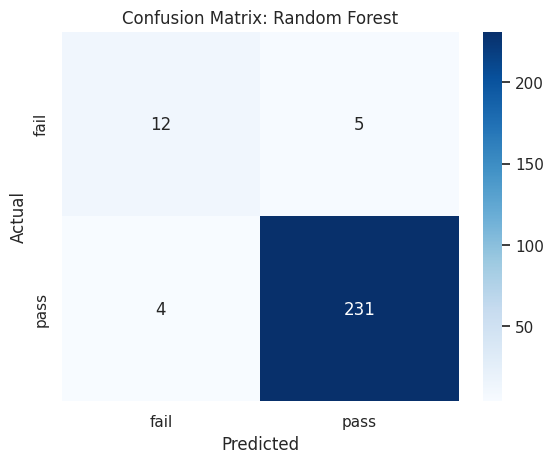

In [9]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["fail", "pass"], yticklabels=["fail", "pass"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Random Forest")
plt.show()


In [10]:
print(df.columns.tolist())

['cpu_pct_avg', 'status', 'hour', 'dayofweek', 'mem_mb', 'log_duration', 'tag_code']
